In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')

    # EDIT - aby zadziałało uruchamianie w Jupyter Notebooku niezbędne jest dodania jeszcze obsługi argumentu -f
    parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )

    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
        print('Device: CUDA GPU')
    elif use_mps:
        device = torch.device("mps")
        print('Device: MPS')
    else:
        device = torch.device("cpu")
        print('Device: CPU')

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('data', train=False, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn_2.pt")

In [3]:
main()

Device: CPU
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305400
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.359776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.842926
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.593794
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.366339
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.469820
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.261667
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.283548
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.587611
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.219924
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.241445
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.351524
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.189557
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.216883
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.252099
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.091920
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.270077
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.099458
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.493011
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.267614
Train Epoch: 1 [1

In [4]:
import idx2numpy
import matplotlib.pyplot as plt

imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)

Wizualizacja jednego obrazu (z tablicy numpy, dane do modelu podawane są w formie numerycznej)

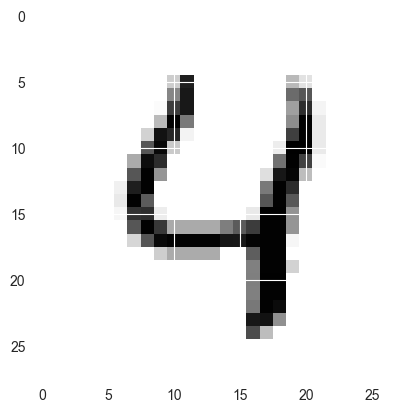

In [5]:
plt.imshow(imagearray[4], cmap=plt.cm.binary)

## Inferencja z wcześniej wytrenowanego i zapisanego modelu PyTorch

In [8]:
model = Net()
model.load_state_dict(torch.load("mnist_cnn_2.pt", weights_only=True))
model.eval()

model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Ustawiamy ile obrazów będzie ładowanych do tensora przy pojedynczej iteracji test loadera

In [9]:
batch_size = 8

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
test_kwargs = {'batch_size': batch_size}

# inicjalizacja zbioru jak w skrypcie głównym
dataset2 = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Ustalenie ile iteracji ładowania danych z data loadera obsłuży poniższa pętla.
Cały zbiór testowy zawiera 10k obrazów, więc nie chcemy ich tutaj wczystkich wyświetlać.
### Zadanie 4

<Figure size 640x480 with 0 Axes>

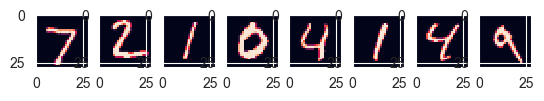

target: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predykcja: tensor([7, 2, 1, 0, 4, 1, 4, 9])


<Figure size 640x480 with 0 Axes>

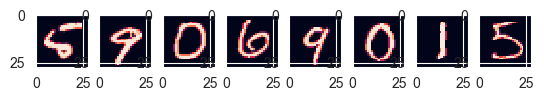

target: tensor([5, 9, 0, 6, 9, 0, 1, 5])
Predykcja: tensor([5, 9, 0, 6, 9, 0, 1, 5])


<Figure size 640x480 with 0 Axes>

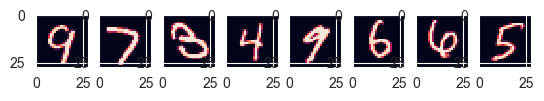

target: tensor([9, 7, 3, 4, 9, 6, 6, 5])
Predykcja: tensor([9, 7, 3, 4, 9, 6, 6, 5])


<Figure size 640x480 with 0 Axes>

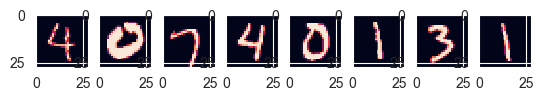

target: tensor([4, 0, 7, 4, 0, 1, 3, 1])
Predykcja: tensor([4, 0, 7, 4, 0, 1, 3, 1])


<Figure size 640x480 with 0 Axes>

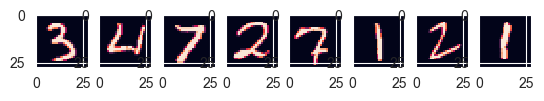

target: tensor([3, 4, 7, 2, 7, 1, 2, 1])
Predykcja: tensor([3, 4, 7, 2, 7, 1, 2, 1])


<Figure size 640x480 with 0 Axes>

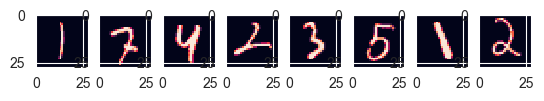

target: tensor([1, 7, 4, 2, 3, 5, 1, 2])
Predykcja: tensor([1, 7, 4, 2, 3, 5, 1, 2])


<Figure size 640x480 with 0 Axes>

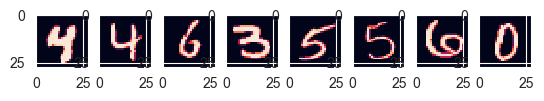

target: tensor([4, 4, 6, 3, 5, 5, 6, 0])
Predykcja: tensor([4, 4, 6, 3, 5, 5, 6, 0])


<Figure size 640x480 with 0 Axes>

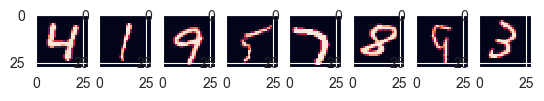

target: tensor([4, 1, 9, 5, 7, 8, 9, 3])
Predykcja: tensor([4, 1, 9, 5, 7, 8, 5, 3])


In [11]:
batches = 8 # ostrożnie!
start = 0

for data, target in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1, batch_size)
    for idx, img in enumerate(data):
        axarr[idx].imshow(img.squeeze(), interpolation='nearest')
    plt.show()
    print(f"target: {target}")
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        print(f"Predykcja: {predicted_classes}")
    start += 1
    if start == batches:
        break

### Zadanie 5

In [22]:
batch_size = 100
test_kwargs = {'batch_size': batch_size}
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

misclassified  = []

for (data, target) in test_loader:
    with torch.no_grad():
        output = model(data)
        top_probs, top_classes = torch.topk(output, k=3, dim=1)
        incorrect_indices = (top_classes[:, 0] != target).nonzero(as_tuple=True)[0]

        for index in incorrect_indices:
            misclassified .append({
                'image': data[index],
                'true_label': target[index].item(),
                'top_classes': top_classes[index].tolist(),
                'top_probs': [round(prob, 4) for prob in top_probs[idx].exp().tolist()]
            })

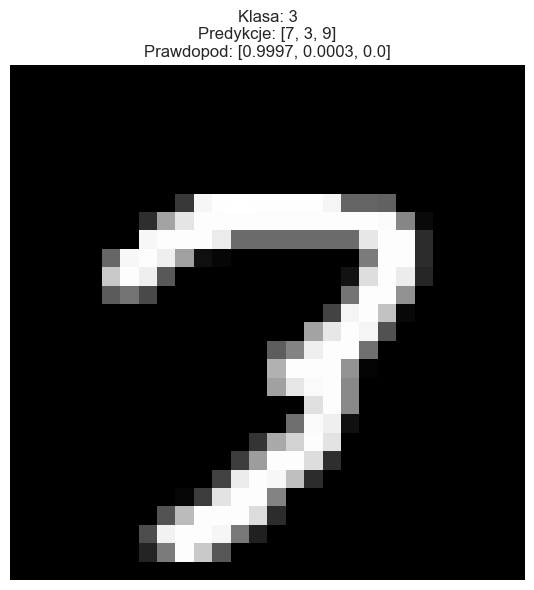

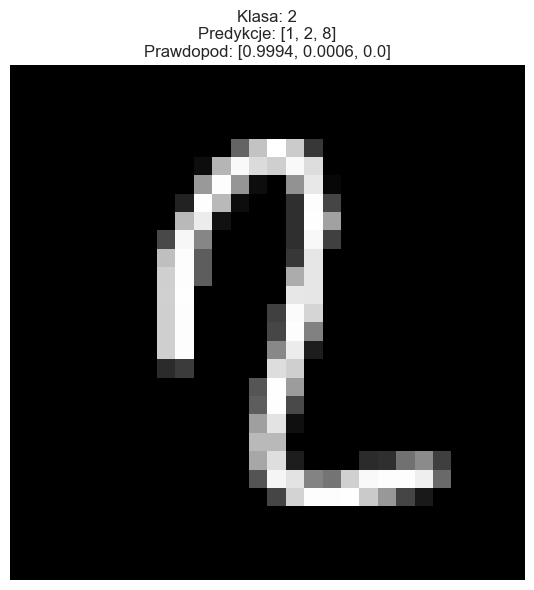

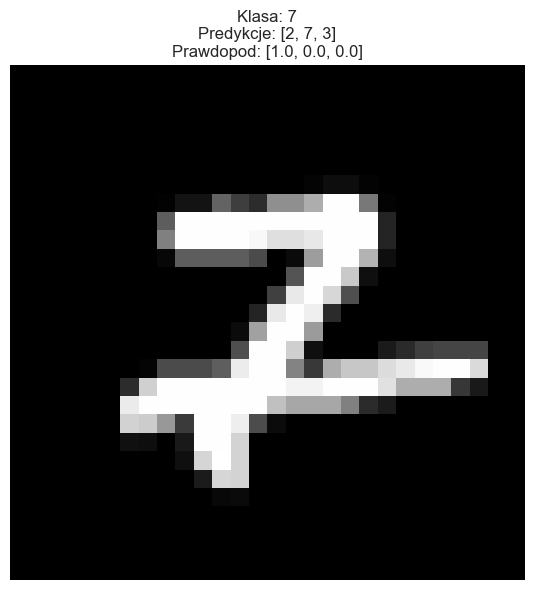

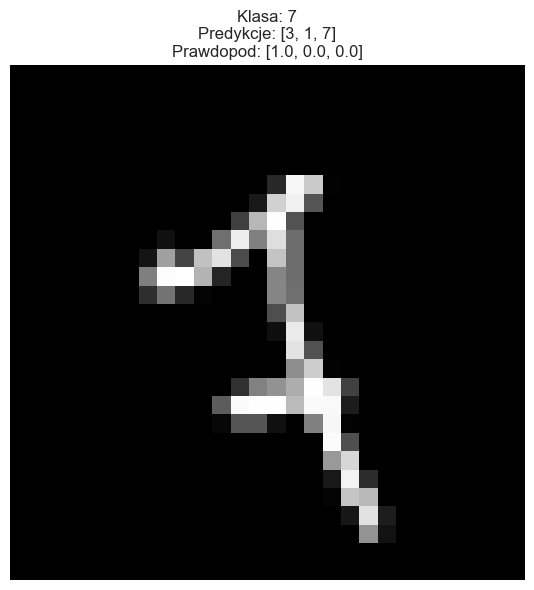

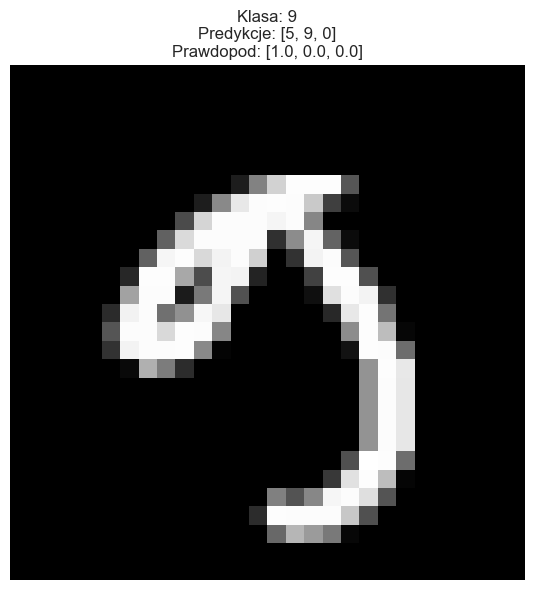

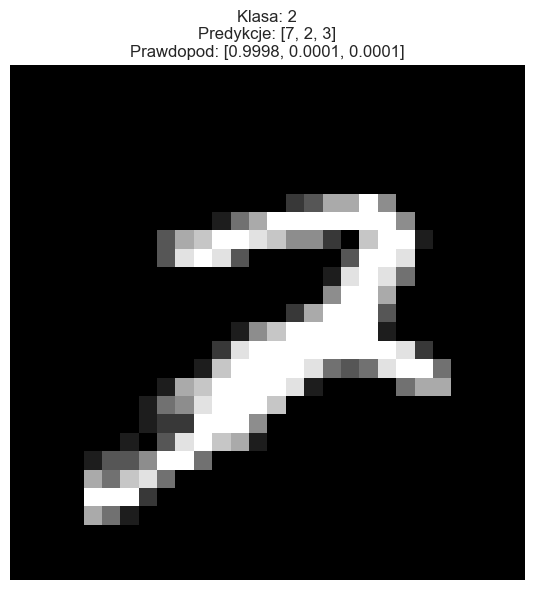

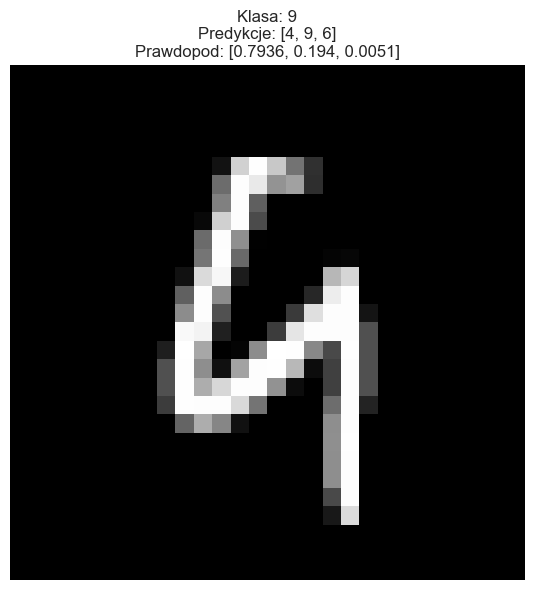

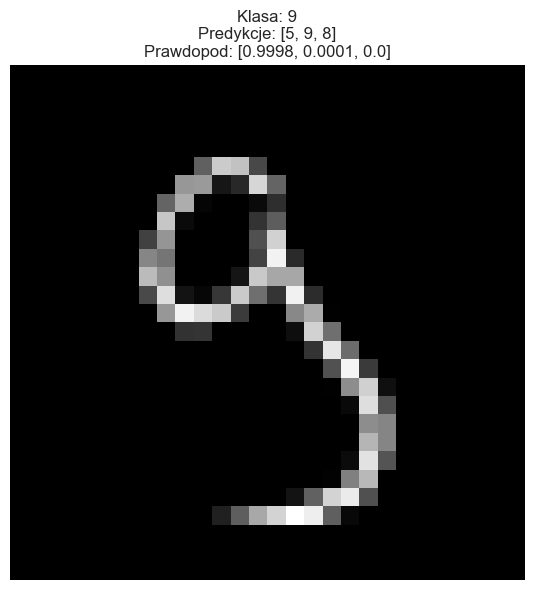

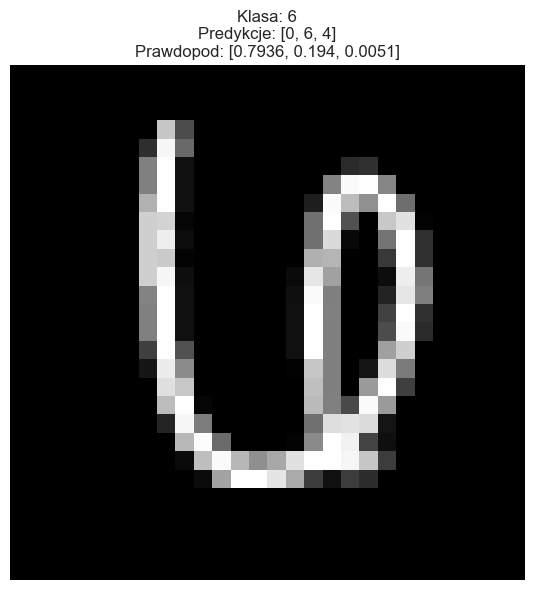

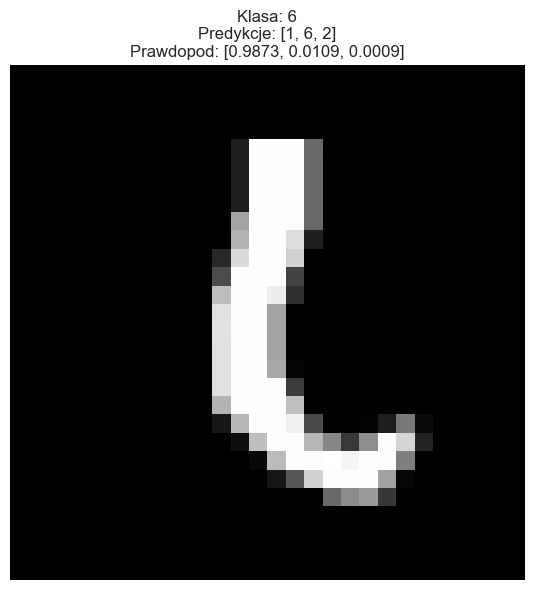

In [23]:
import random

random.shuffle(misclassified)

for result in misclassified[:10]:
    plt.figure(figsize=(8, 6))
    plt.imshow(result['image'].squeeze(), cmap='gray')
    plt.title(f'Klasa: {result['true_label']}\n'
              f'Predykcje: {result['top_classes']}\n'
              f'Prawdopod: {result['top_probs']}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()